In [2]:
import sys, os, os.path
if not 'EXPERIMENT_HOME' in os.environ: # Configure local paths if not already defined
    ML_HOME = os.path.abspath(os.path.join("/home/jovyan", "ml_home")) # ML workspace
    EXPERIMENT_HOME = os.path.abspath(os.path.join(ML_HOME, "..")) # Experiment workspace
    DATA_HOME = os.path.abspath(os.path.join(EXPERIMENT_HOME,"dataset")) # Dataset location
    os.environ["EXPERIMENT_HOME"] = EXPERIMENT_HOME
    os.environ["DATA_HOME"] = DATA_HOME
    sys.path.insert(0, EXPERIMENT_HOME)
    sys.path.insert(0, ML_HOME) # Add to path so can load our library
    os.chdir(EXPERIMENT_HOME) # Change working directory to experiment workspace
print("Experiment Home: ", os.path.abspath(os.curdir), "; Data Home:", DATA_HOME)

Experiment Home:  /home/jovyan ; Data Home: /home/jovyan/dataset


In [3]:
from datetime import datetime
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime as dt
import xlrd
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
from data.snapshot import SET100, SET100_db_engine, make_index

In [10]:
engine = SET100_db_engine()


# Read facts Table

In [11]:
facts = pd.read_sql('SELECT * FROM set100_daily_facts', con=engine)
make_index(facts)

stock       date  \
stock                   date                                             
ASIA AVIATION           2015-01-01            ASIA AVIATION 2015-01-01   
                        2015-01-02            ASIA AVIATION 2015-01-02   
                        2015-01-05            ASIA AVIATION 2015-01-05   
                        2015-01-06            ASIA AVIATION 2015-01-06   
                        2015-01-07            ASIA AVIATION 2015-01-07   
...                                                     ...        ...   
WORKPOINT ENTERTAINMENT 2019-12-25  WORKPOINT ENTERTAINMENT 2019-12-25   
                        2019-12-26  WORKPOINT ENTERTAINMENT 2019-12-26   
                        2019-12-27  WORKPOINT ENTERTAINMENT 2019-12-27   
                        2019-12-30  WORKPOINT ENTERTAINMENT 2019-12-30   
                        2019-12-31  WORKPOINT ENTERTAINMENT 2019-12-31   

                                              VO            MV      P  MACD  
stock                   date                                                 
ASIA AVIATION           2015-01-01           NaN  2.085500e+10   4.30  0.00  
                        2015-01-02           NaN  2.085500e+10   4.30  0.00  
                        2015-01-05  1.656740e+10  2.085500e+10   4.30  0.00  
                        2015-01-06  5.923020e+10  2.201899e+10   4.54  0.02  
                        2015-01-07  2.404850e+10  2.221299e+10   4.58  0.04  
...                                          ...           ...    ...   ...  
WORKPOINT ENTERTAINMENT 2019-12-25  1.918200e+09  6.005220e+09  13.60 -0.69  
                        2019-12-26  1.907000e+09  6.137690e+09  13.90 -0.62  
                        2019-12-27  1.587200e+09  6.226000e+09  14.10 -0.55  
                        2019-12-30  1.590000e+08  6.181840e+09  14.00 -0.49  
                        2019-12-31           NaN  6.181840e+09  14.00 -0.43  

[208640 rows x 6 columns]

# Select Study Period

We move to SQL. This alevate memory burden of the 'facts' dataframe with multiindex used earlier.

In [19]:
# Declare class StudyPeriod for convenient
from datetime import timedelta
from datetime import datetime as dt

class StudyPeriod:
    min_date = dt(year=2015,month=1,day=1)
    max_date = dt(year=2019,month=1,day=31)
    def __init__(self, year=None, month=None, day=None):
        self.year = year
        self.month = month
        self.day = day
        self.d1 = dt(year=year,month=month,day=day)
        self.date = {1: d1}
        self.w1 = dt(year=year,month=month,day=day)
        self.week = {1: w1}
        self.m1 = dt(year=year,month=month,day=day)
        self.month = {1: m1}
        
d1 = dt(year=2015,month=1,day=1)
d2 = dt(year=2019,month=1,day=31)
d2 - d1 # datetime.timedelta(days=1491)

timedelta(weeks=10)

datetime.timedelta(days=70)

### Select one month

In [21]:
# facts['WORKPOINT ENTERTAINMENT','2016-01-01':'2016-01-02']

# Select by date
sql = """SELECT f.* FROM set100_daily_facts f
WHERE f.date BETWEEN '2016-01-01' AND '2016-02-01';"""
df_read = pd.read_sql(sql, engine)
df_read

,stock,date,VO,MV,P,MACD
0,ASIA AVIATION,2016-01-01,NaN,2.546249e+10,5.25,0.15
1,ASIA AVIATION,2016-01-04,8.310700e+09,2.497749e+10,5.15,0.14
2,ASIA AVIATION,2016-01-05,3.927690e+10,2.521999e+10,5.20,0.14
3,ASIA AVIATION,2016-01-06,4.447000e+10,2.594750e+10,5.35,0.16
4,ASIA AVIATION,2016-01-07,4.197290e+10,2.667499e+10,5.50,0.17
...,...,...,...,...,...,...
3515,WORKPOINT ENTERTAINMENT,2016-01-26,2.506000e+08,1.669020e+10,40.00,-0.69
3516,WORKPOINT ENTERTAINMENT,2016-01-27,1.349000e+08,1.648157e+10,39.50,-0.79
3517,WORKPOINT ENTERTAINMENT,2016-01-28,4.739000e+08,1.627294e+10,39.00,-0.90
3518,WORKPOINT ENTERTAINMENT,2016-01-29,1.753000e+08,1.606432e+10,38.50,-1.01


In [22]:
vo = df_read['VO'].dropna()
vo

1       8.310700e+09
2       3.927690e+10
3       4.447000e+10
4       4.197290e+10
5       5.175110e+10
            ...     
3515    2.506000e+08
3516    1.349000e+08
3517    4.739000e+08
3518    1.753000e+08
3519    1.611000e+08
Name: VO, Length: 3086, dtype: float64

In [23]:

from talib.abstract import *

In [24]:
n = 20
inputs = vo
daily_vo_sma = SMA(inputs, timeperiod=n)

In [25]:
daily_vo_sma

array([       nan,        nan,        nan, ..., 7.4108e+08, 3.1967e+08,
       2.9871e+08])

In [26]:
# After building feature in AddFeatureSetV4

In [27]:
# facts['WORKPOINT ENTERTAINMENT','2016-01-01':'2016-01-02']

# Select by date
sql = """SELECT f.* FROM set100_daily_features f
WHERE f.date BETWEEN '2016-01-01' AND '2016-02-01';"""
df_read = pd.read_sql(sql, engine)
df_read

,stock,date,VO,VO_SMA_20,VO_SMA_100,vol_st,MV,MV_SMA_20,MV_SMA_100,mv_st,P,P_SMA_5,P_SMA_20,p_st,MACD
0,ASIA AVIATION,2016-01-01,None,NaN,NaN,NaN,25462490000.0,2.361464e+10,2.230514e+10,0.058708,5.25,5.18,4.8690,0.063873,0.15
1,ASIA AVIATION,2016-01-04,8310700.000000001,16932725.0,16197706.0,0.045378,24977490000.0,2.377712e+10,2.233279e+10,0.064673,5.15,5.21,4.9025,0.062723,0.14
2,ASIA AVIATION,2016-01-05,39276900.0,17876495.0,16439221.0,0.087430,25219990000.0,2.394687e+10,2.238323e+10,0.069858,5.2,5.22,4.9375,0.057215,0.14
3,ASIA AVIATION,2016-01-06,44470000,19519430.0,16472412.0,0.184977,25947500000.0,2.414329e+10,2.243512e+10,0.076138,5.35,5.24,4.9780,0.052632,0.16
4,ASIA AVIATION,2016-01-07,41972900.0,21368955.0,16305517.0,0.310535,26674990000.0,2.437609e+10,2.249332e+10,0.083703,5.5,5.29,5.0260,0.052527,0.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3271,WORKPOINT ENTERTAINMENT,2016-01-26,250600.0,311675.0,554743.0,-0.438163,16690200000.0,1.750906e+10,1.797266e+10,-0.025794,40,41.00,41.9625,-0.022937,-0.69
3272,WORKPOINT ENTERTAINMENT,2016-01-27,134900.0,316020.0,544603.0,-0.419724,16481570000.0,1.742040e+10,1.794763e+10,-0.029376,39.5,40.65,41.7500,-0.026347,-0.79
3273,WORKPOINT ENTERTAINMENT,2016-01-28,473900.0,320810.0,512457.0,-0.373977,16272940000.0,1.732130e+10,1.792052e+10,-0.033438,39,40.20,41.5125,-0.031617,-0.9
3274,WORKPOINT ENTERTAINMENT,2016-01-29,175300.0,319670.0,503141.0,-0.364651,16064320000.0,1.721177e+10,1.789445e+10,-0.038151,38.5,39.60,41.2500,-0.040000,-1.01


In [81]:
f_dim3 = df_read[['stock','date','vol_st','MACD','P_SMA_5']]

In [82]:
f_dim3.dropna()

,stock,date,vol_st,MACD,P_SMA_5
1,ASIA AVIATION,2016-01-04,0.045378,0.14,5.21
2,ASIA AVIATION,2016-01-05,0.087430,0.14,5.22
3,ASIA AVIATION,2016-01-06,0.184977,0.16,5.24
4,ASIA AVIATION,2016-01-07,0.310535,0.17,5.29
5,ASIA AVIATION,2016-01-08,0.410291,0.19,5.34
...,...,...,...,...,...
3271,WORKPOINT ENTERTAINMENT,2016-01-26,-0.438163,-0.69,41.00
3272,WORKPOINT ENTERTAINMENT,2016-01-27,-0.419724,-0.79,40.65
3273,WORKPOINT ENTERTAINMENT,2016-01-28,-0.373977,-0.9,40.20
3274,WORKPOINT ENTERTAINMENT,2016-01-29,-0.364651,-1.01,39.60


## PCA

In [94]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)

In [96]:
spot = f_dim3.dropna()

X = spot[['vol_st','MACD','P_SMA_5']]

In [97]:
y = spot[['stock', 'date']]

In [98]:
pca.fit(X)
pca

PCA(n_components=3)

In [99]:
pca.n_components_

3

In [100]:
pca.explained_variance_

array([2.91578043e+03, 2.10373704e+00, 2.65067581e-01])

In [101]:
pca.components_

array([[ 0.0016099 , -0.01126583,  0.99993524],
       [ 0.03997703, -0.99913646, -0.01132119],
       [ 0.9991993 ,  0.03999266, -0.00115814]])

In [102]:
df = pd.DataFrame(X) # This is original data frame
df

# df['y'] = y['stock'].values  # Label with stock name. We will try with date later
# df['yd'] = y['date'].values

,vol_st,MACD,P_SMA_5
1,0.045378,0.14,5.21
2,0.087430,0.14,5.22
3,0.184977,0.16,5.24
4,0.310535,0.17,5.29
5,0.410291,0.19,5.34
...,...,...,...
3271,-0.438163,-0.69,41.00
3272,-0.419724,-0.79,40.65
3273,-0.373977,-0.9,40.20
3274,-0.364651,-1.01,39.60


In [103]:
X

,vol_st,MACD,P_SMA_5
1,0.045378,0.14,5.21
2,0.087430,0.14,5.22
3,0.184977,0.16,5.24
4,0.310535,0.17,5.29
5,0.410291,0.19,5.34
...,...,...,...
3271,-0.438163,-0.69,41.00
3272,-0.419724,-0.79,40.65
3273,-0.373977,-0.9,40.20
3274,-0.364651,-1.01,39.60


In [104]:
pca_features = pca.transform(X)
df_pc = pd.DataFrame(pca_features)
df_pc # this is PC1, PC2, PC3

,0,1,2
0,-24.487244,-0.172867,0.074570
1,-24.477177,-0.171299,0.116577
2,-24.457246,-0.187609,0.214823
3,-24.407160,-0.193147,0.340622
4,-24.357228,-0.209708,0.441040
...,...,...,...
2977,11.309011,0.231900,-0.483227
2978,10.960190,0.336513,-0.468397
2979,10.511532,0.453342,-0.426564
2980,9.912825,0.570412,-0.420951


In [105]:
df_pc['y'] = y['stock'].values  # Label with stock name. We will try with date later
df_pc['yd'] = y['date'].values

In [64]:
df_pc

,0,1,2,y,yd
0,-24.487244,-0.172867,0.074570,ASIA AVIATION,2016-01-04
1,-24.477177,-0.171299,0.116577,ASIA AVIATION,2016-01-05
2,-24.457246,-0.187609,0.214823,ASIA AVIATION,2016-01-06
3,-24.407160,-0.193147,0.340622,ASIA AVIATION,2016-01-07
4,-24.357228,-0.209708,0.441040,ASIA AVIATION,2016-01-08
...,...,...,...,...,...
2977,11.309011,0.231900,-0.483227,WORKPOINT ENTERTAINMENT,2016-01-26
2978,10.960190,0.336513,-0.468397,WORKPOINT ENTERTAINMENT,2016-01-27
2979,10.511532,0.453342,-0.426564,WORKPOINT ENTERTAINMENT,2016-01-28
2980,9.912825,0.570412,-0.420951,WORKPOINT ENTERTAINMENT,2016-01-29


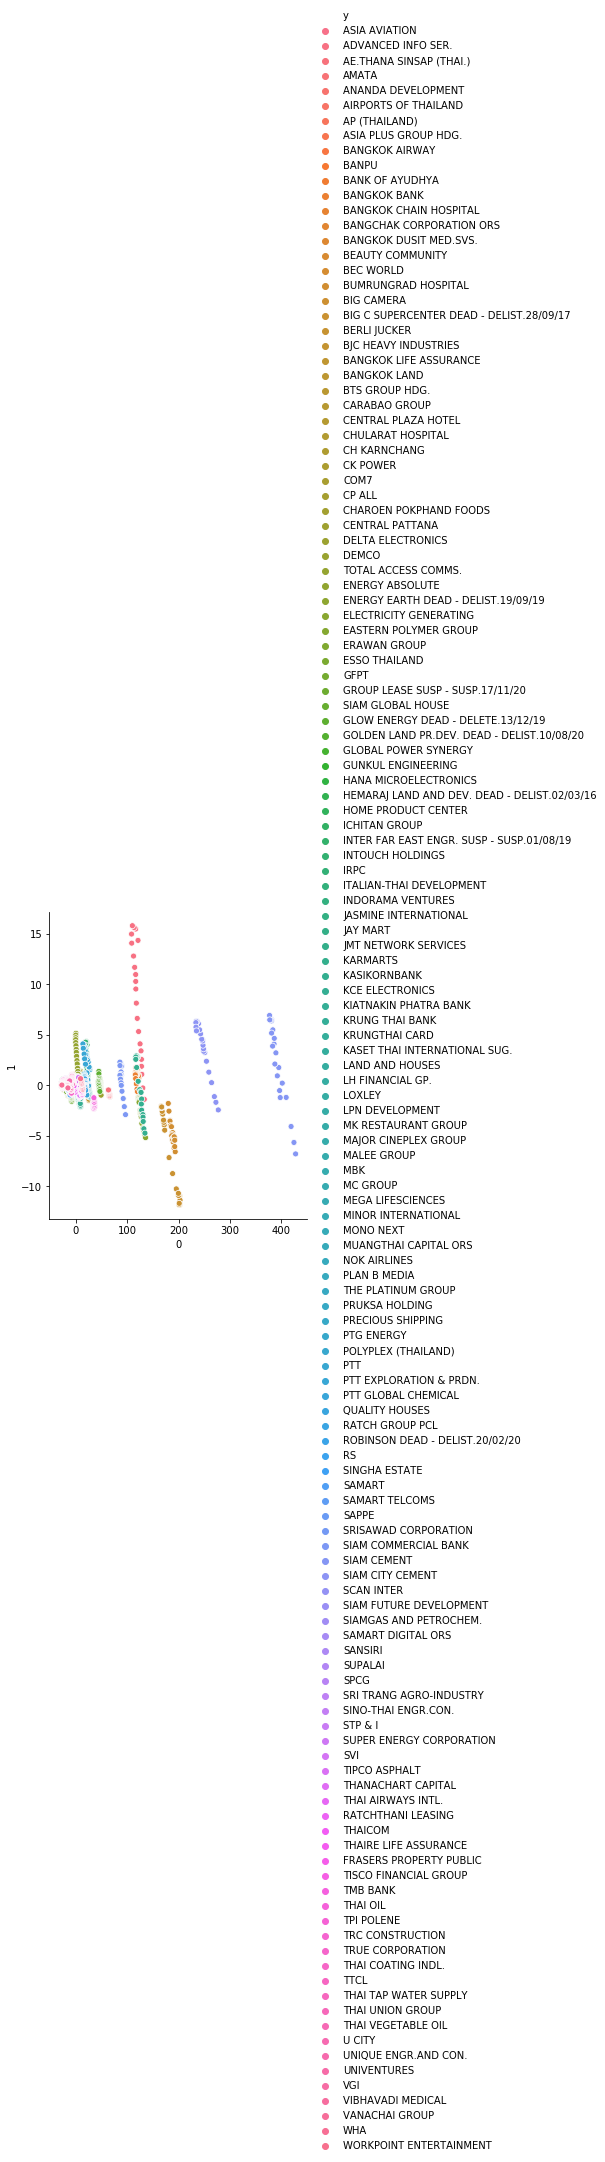

In [65]:
import seaborn as sns
# df2.plot.scatter(x=0,y=1)
sns.relplot(x=0, y=1, hue="y", data=df_pc);

<string>:6: UserWarning: Warning: converting a masked element to nan.
/opt/conda/lib/python3.7/site-packages/numpy/ma/core.py:717: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


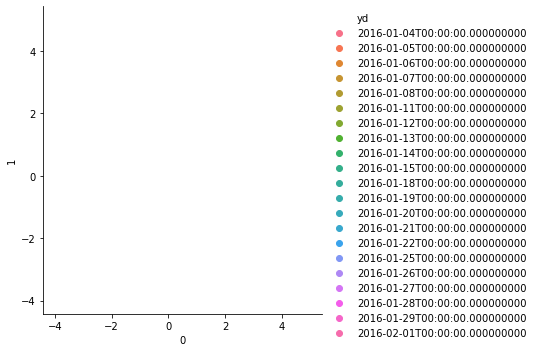

In [66]:

sns.relplot(x=0, y=1, hue="yd", data=df_pc)

In [72]:
# K-means
# Set k=2, PC1,PC2 as variabless
from sklearn.cluster import KMeans


kmean = KMeans(n_clusters=4, random_state=0)
kmean.fit(df_pc[[0,1]].values)

KMeans(n_clusters=4, random_state=0)

In [73]:
kmean.cluster_centers_

array([[-2.02120456e+01, -2.27787571e-03],
       [ 1.35764736e+02, -6.78850684e-01],
       [ 3.20808332e+02,  2.80538629e+00],
       [ 1.41474727e+01, -1.97003635e-02]])

In [74]:
kmean.labels_

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [75]:
# kmean.labels_
df_pc['k-mean'] = kmean.labels_

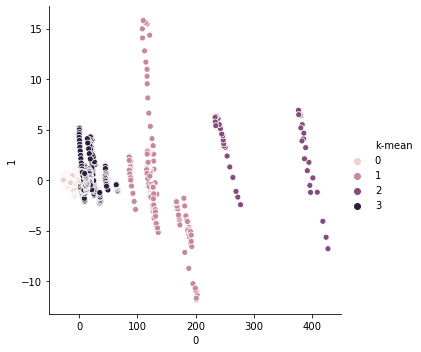

In [76]:
sns.relplot(x=0, y=1, hue="k-mean", data=df_pc)

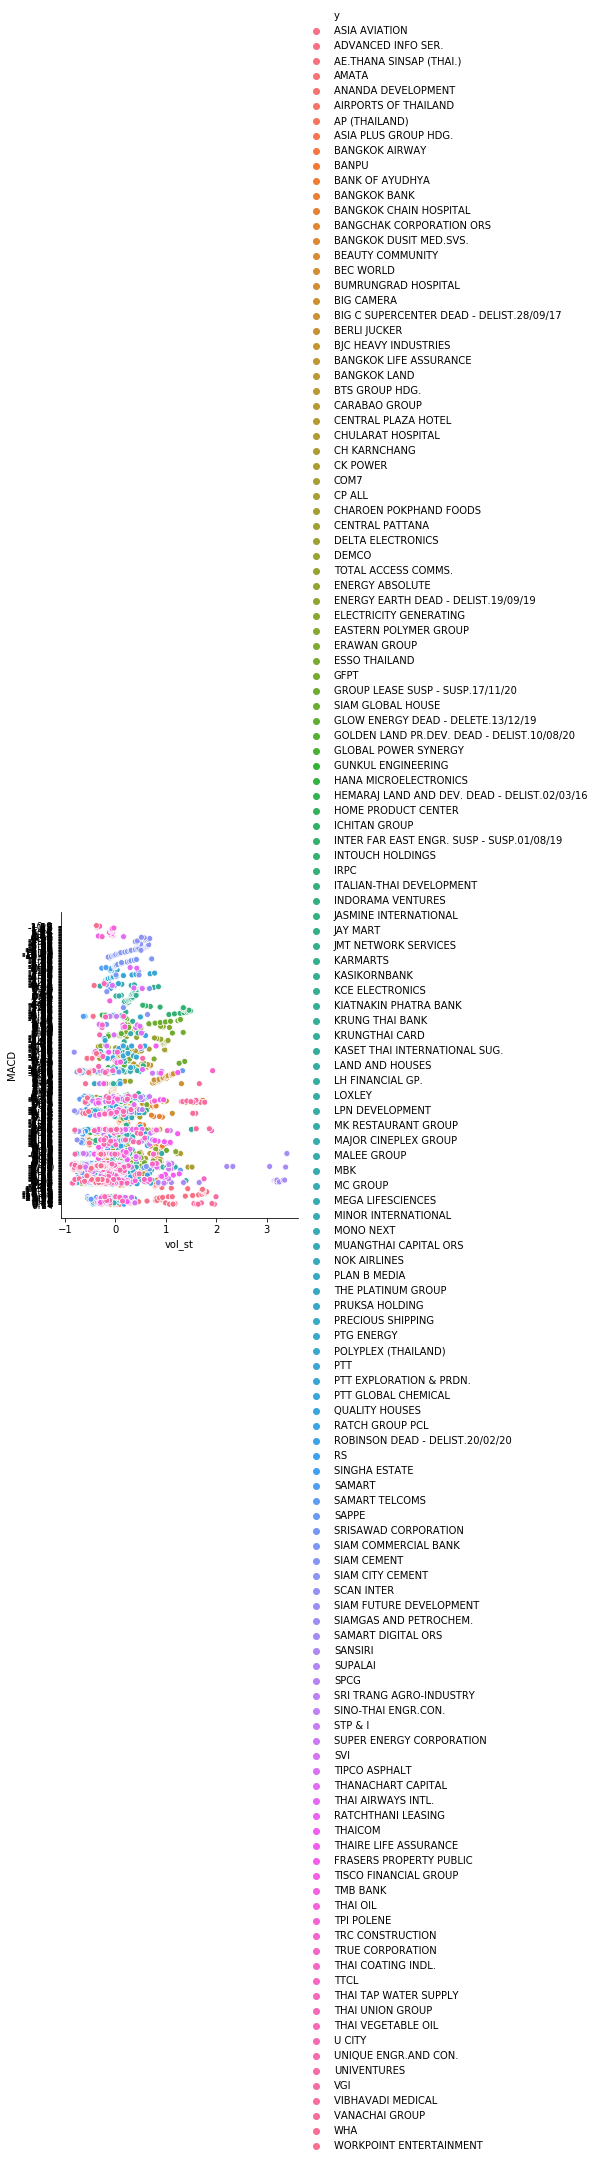

In [108]:
df['y'] = y['stock'].values  # Label with stock name. We will try with date later
df['yd'] = y['date'].values
sns.relplot(x="vol_st", y="MACD", hue="y", data=df);

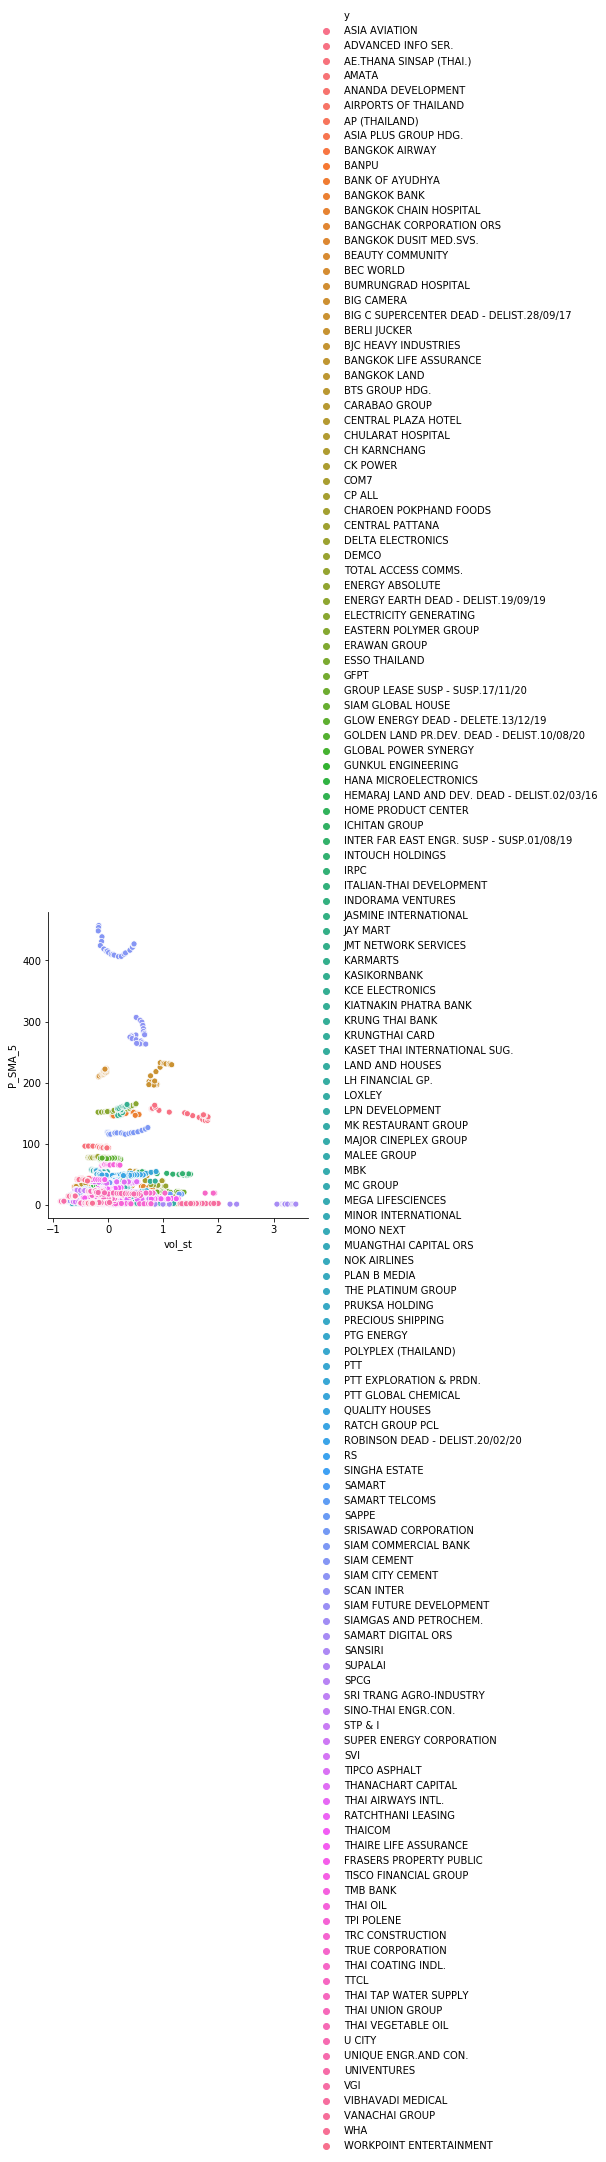

In [109]:
df['y'] = y['stock'].values  # Label with stock name. We will try with date later
df['yd'] = y['date'].values
sns.relplot(x="vol_st", y="P_SMA_5", hue="y", data=df);

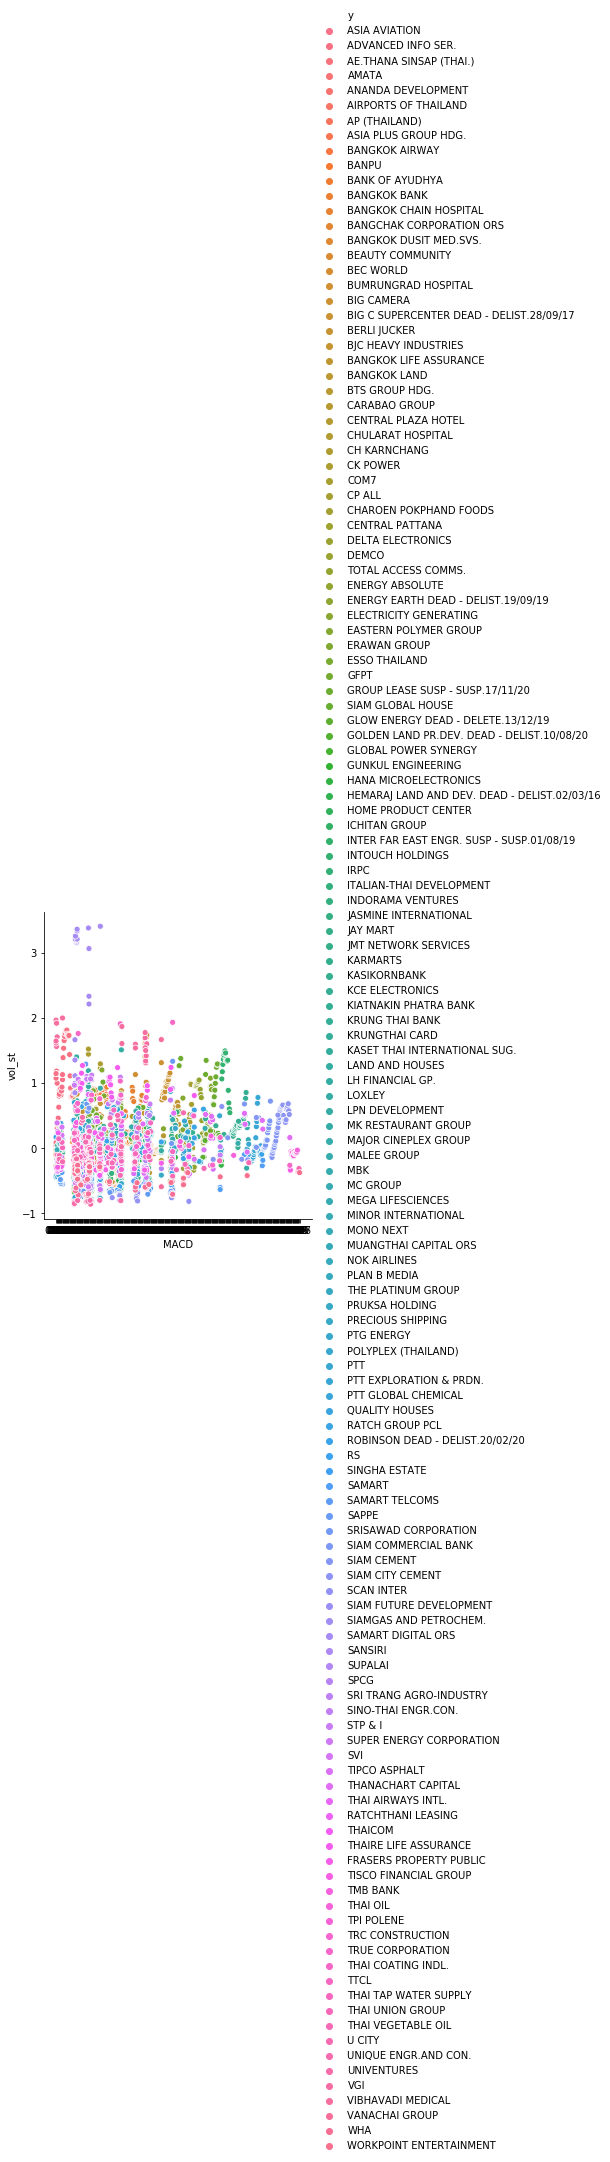

In [111]:
df['y'] = y['stock'].values  # Label with stock name. We will try with date later
df['yd'] = y['date'].values
sns.relplot(x="MACD", y="vol_st", hue="y", data=df);

In [110]:
df

,vol_st,MACD,P_SMA_5,y,yd
1,0.045378,0.14,5.21,ASIA AVIATION,2016-01-04
2,0.087430,0.14,5.22,ASIA AVIATION,2016-01-05
3,0.184977,0.16,5.24,ASIA AVIATION,2016-01-06
4,0.310535,0.17,5.29,ASIA AVIATION,2016-01-07
5,0.410291,0.19,5.34,ASIA AVIATION,2016-01-08
...,...,...,...,...,...
3271,-0.438163,-0.69,41.00,WORKPOINT ENTERTAINMENT,2016-01-26
3272,-0.419724,-0.79,40.65,WORKPOINT ENTERTAINMENT,2016-01-27
3273,-0.373977,-0.9,40.20,WORKPOINT ENTERTAINMENT,2016-01-28
3274,-0.364651,-1.01,39.60,WORKPOINT ENTERTAINMENT,2016-01-29


# Scaling with MinMaxScaler

In [180]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
spot = f_dim3.dropna()
# https://stackoverflow.com/questions/40755680/how-to-reset-index-pandas-dataframe-after-dropna-pandas-dataframe
spot.reset_index(drop=True, inplace=True) # Need reindex
X = spot[['vol_st','MACD','P_SMA_5', 'MV', 'VOL_SMA_20']]

sc.fit(X)

KeyError: "['MV', 'VOL_SMA_20'] not in index"

In [167]:
X

,vol_st,MACD,P_SMA_5
0,0.045378,0.14,5.21
1,0.087430,0.14,5.22
2,0.184977,0.16,5.24
3,0.310535,0.17,5.29
4,0.410291,0.19,5.34
...,...,...,...
2977,-0.438163,-0.69,41.00
2978,-0.419724,-0.79,40.65
2979,-0.373977,-0.9,40.20
2980,-0.364651,-1.01,39.60


In [168]:
X_scaled = pd.DataFrame(sc.transform(X))
X_scaled

,0,1,2
0,0.212365,0.655769,0.008903
1,0.222230,0.655769,0.008924
2,0.245113,0.656520,0.008968
3,0.274566,0.656896,0.009078
4,0.297967,0.657648,0.009188
...,...,...,...
2977,0.098935,0.624577,0.087381
2978,0.103261,0.620819,0.086613
2979,0.113992,0.616685,0.085627
2980,0.116180,0.612552,0.084311


In [169]:
 # result = pd.concat([X_scaled, y],axis=1)

In [170]:
pca_1d = decomposition.PCA(n_components=1)
pca_1d.fit(X) # Don't scale

PCA(n_components=1)

In [171]:
pca_1d.explained_variance_  # change from 0.1 to 2915

array([2915.78042941])

In [172]:
y_PC = pd.DataFrame(pca_1d.transform(X))
y_PC

,0
0,-24.487244
1,-24.477177
2,-24.457246
3,-24.407160
4,-24.357228
...,...
2977,11.309011
2978,10.960190
2979,10.511532
2980,9.912825


In [174]:
# Use the spot data frame

spot['PCA_dim'] = y_PC
spot

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,stock,date,vol_st,MACD,P_SMA_5,PCA_dim
0,ASIA AVIATION,2016-01-04,0.045378,0.14,5.21,-24.487244
1,ASIA AVIATION,2016-01-05,0.087430,0.14,5.22,-24.477177
2,ASIA AVIATION,2016-01-06,0.184977,0.16,5.24,-24.457246
3,ASIA AVIATION,2016-01-07,0.310535,0.17,5.29,-24.407160
4,ASIA AVIATION,2016-01-08,0.410291,0.19,5.34,-24.357228
...,...,...,...,...,...,...
2977,WORKPOINT ENTERTAINMENT,2016-01-26,-0.438163,-0.69,41.00,11.309011
2978,WORKPOINT ENTERTAINMENT,2016-01-27,-0.419724,-0.79,40.65,10.960190
2979,WORKPOINT ENTERTAINMENT,2016-01-28,-0.373977,-0.9,40.20,10.511532
2980,WORKPOINT ENTERTAINMENT,2016-01-29,-0.364651,-1.01,39.60,9.912825


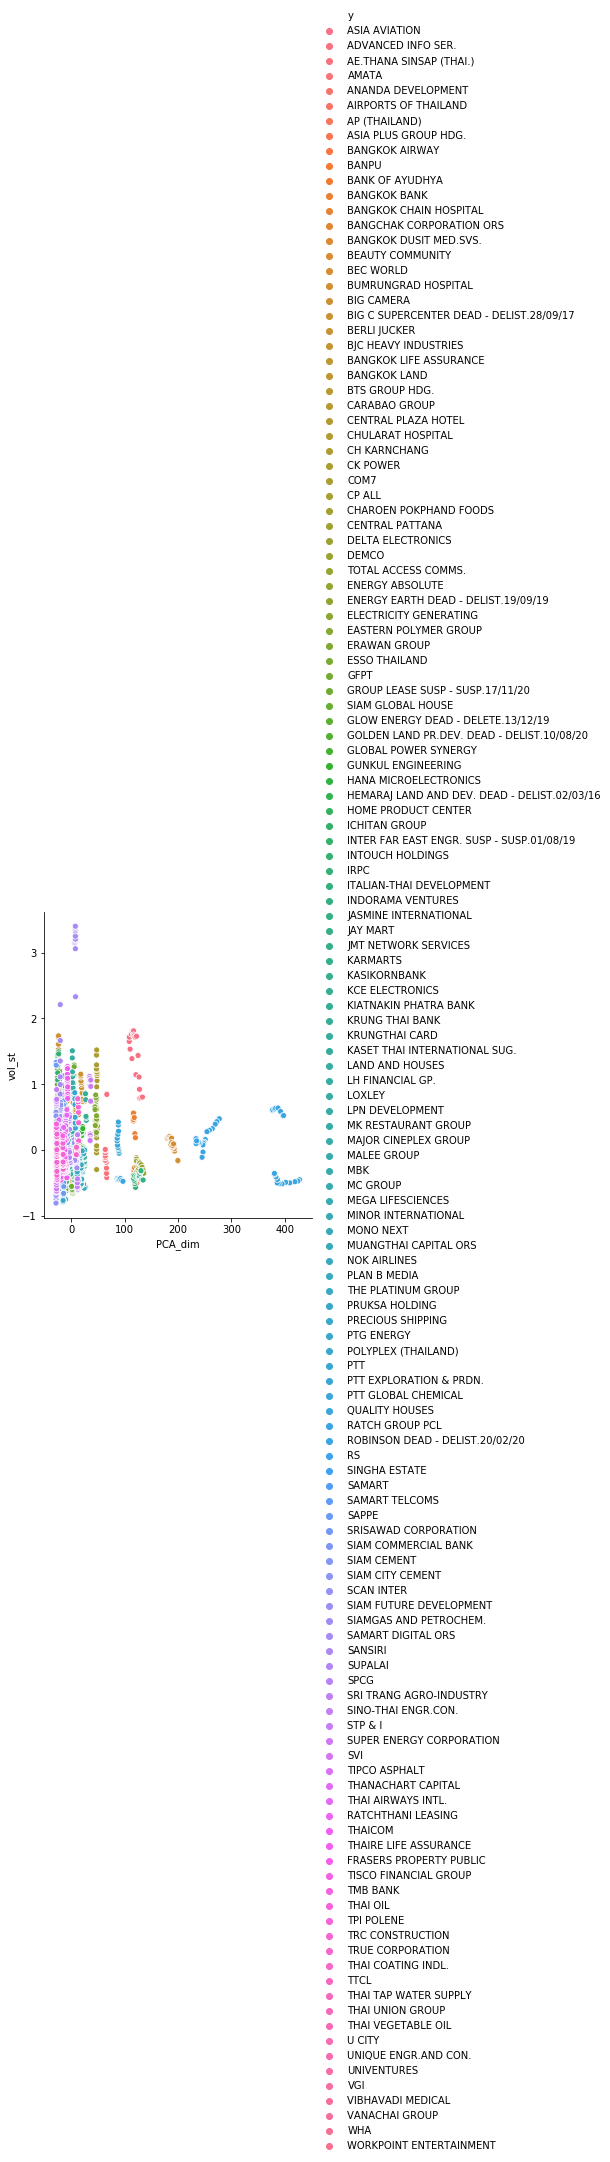

In [176]:
sns.relplot(x="PCA_dim", y="vol_st", hue="y", data=df);

### PCA 2-dim

In [177]:
pca_2d = decomposition.PCA(n_components=2)
pca_2d.fit(X) # Don't scale

PCA(n_components=2)

In [179]:
pca_2d.explained_variance_ 

array([2.91578043e+03, 2.10373704e+00])